In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## This Notebook Aims to display how we calculate the VaR($\Delta$ BOF)

In [37]:
def fetch_data_df():
    df = pd.read_csv('../../data/normalized_asset_classes.csv', index_col=0)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[:, :6]
    return df

In [38]:
df = fetch_data_df()
df.head()

,ACWI.World.Equities,AGGG.World.Debt,AHYG.Asia.Debt,BWX.World.Debt,EDIV.EmergingMarkets.Equities,EEM.EmergingMarkets.Equities
Exchange Date,,,,,,
2024-10-10,277.697674,NaN,NaN,NaN,76.899128,117.359371
2024-10-09,277.976744,NaN,NaN,NaN,76.670818,117.129905
2024-10-08,276.837209,NaN,NaN,NaN,77.231216,117.767312
2024-10-07,276.116279,NaN,NaN,NaN,78.787879,120.750376
2024-10-04,277.860465,NaN,NaN,NaN,77.957659,119.756022


In [39]:
returns_df = df.pct_change(fill_method=None).dropna()
returns_df.head()

,ACWI.World.Equities,AGGG.World.Debt,AHYG.Asia.Debt,BWX.World.Debt,EDIV.EmergingMarkets.Equities,EEM.EmergingMarkets.Equities
Exchange Date,,,,,,


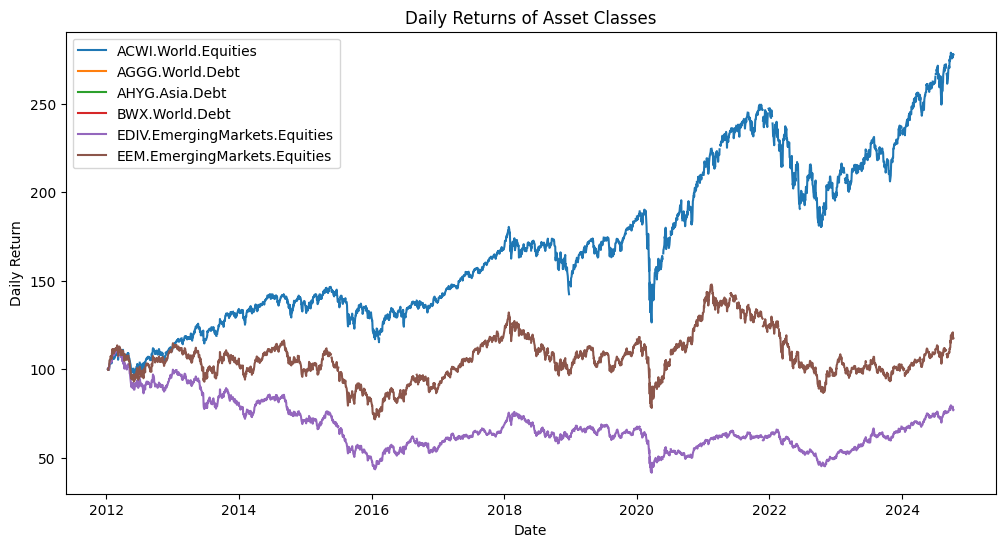

In [40]:
plt.figure(figsize=(12, 6))
for col in df.columns:
    plt.plot(df.index, df[col], label=col)

# Add plot title and labels
plt.title("Daily Returns of Asset Classes")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend(loc="best")
plt.show()

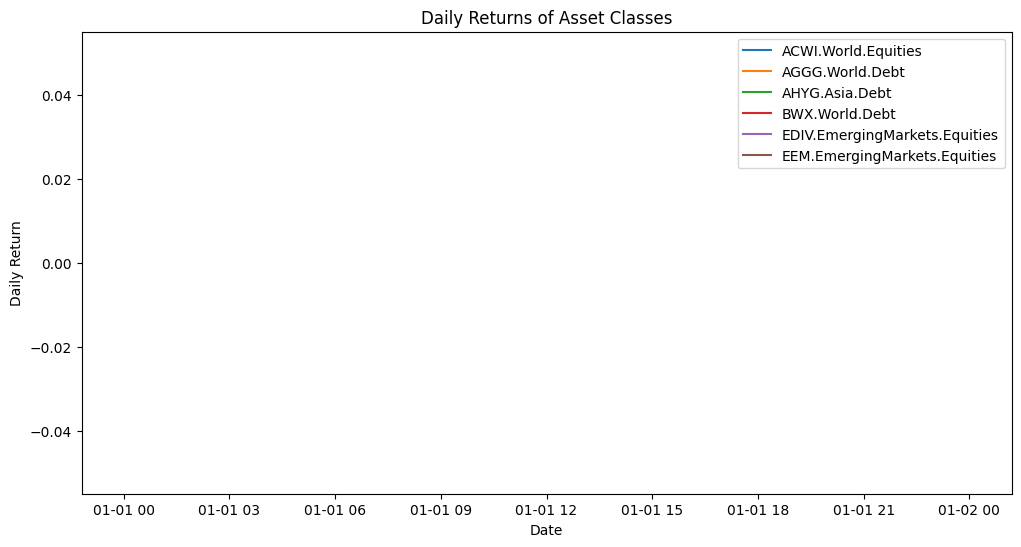

In [41]:
plt.figure(figsize=(12, 6))
for col in returns_df.columns:
    plt.plot(returns_df.index, returns_df[col], label=col)

# Add plot title and labels
plt.title("Daily Returns of Asset Classes")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend(loc="best")
plt.show()

In [188]:
returns_df.shape

(1273, 6)

In [189]:
mean_returns = returns_df.mean()
cov_matrix = returns_df.cov()

n_simulations = 100000
n_days = 252  # 1 year is typically 252 trading days

asset_classes = df.columns

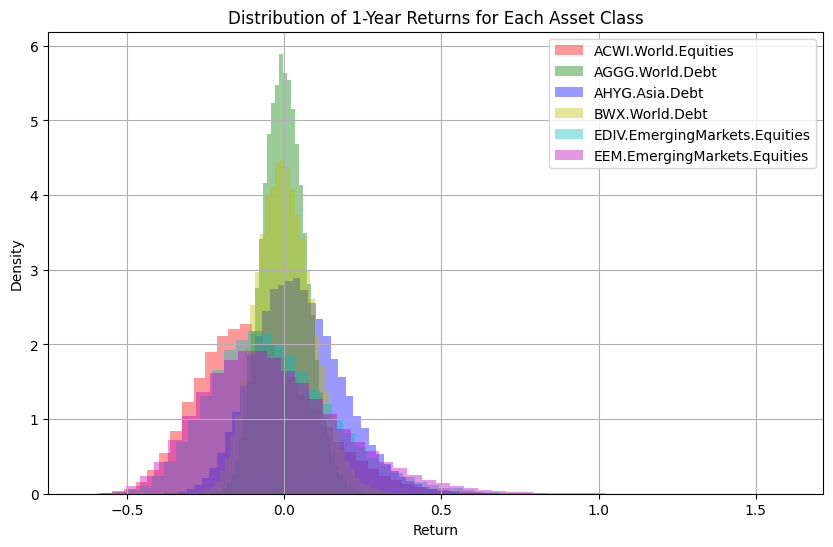

In [190]:
# Simulate daily returns for 1 year using the multivariate normal distribution
simulated_daily_returns = np.random.multivariate_normal(mean_returns, cov_matrix, (n_simulations, n_days))

# Calculate cumulative returns for each asset class over 1 year
simulated_cumulative_returns = np.cumprod(1 + simulated_daily_returns, axis=1)[:, -1] - 1

plt.figure(figsize=(10, 6))

colors = ['r', 'g', 'b', 'y', 'c', 'm']  # Colors for each asset class (adjust to match the number of assets)

for i, asset_class in enumerate(asset_classes):
    plt.hist(simulated_cumulative_returns[:, i], bins=50, alpha=0.4, color=colors[i], label=asset_class, density=True)

plt.title('Distribution of 1-Year Returns for Each Asset Class')
plt.xlabel('Return')
plt.ylabel('Density')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()


Now make same plot but for basic own funds

In [191]:
assets_0 = 1000000
liabilities_0 = assets_0 * 0.6
liability_growth = 0.03

weights = np.array([0.0, 0.8, 0.1, 0.095, 0.0, 0.05]) 

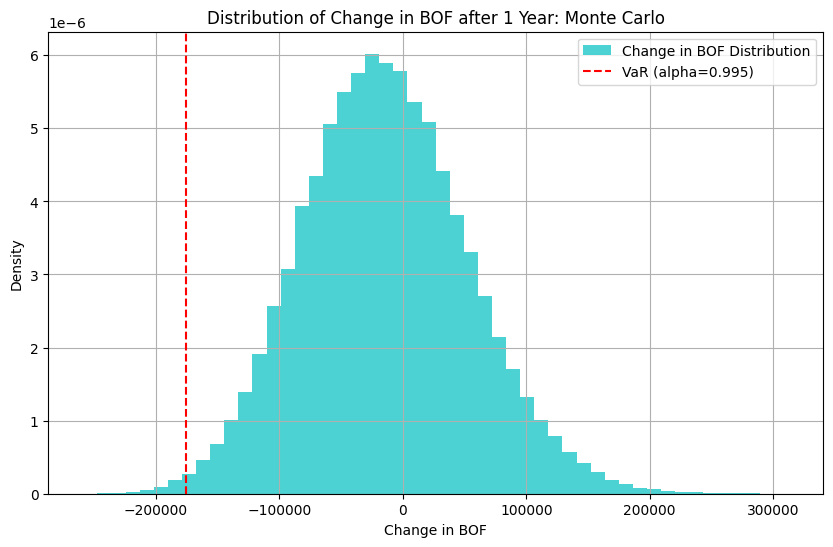

In [192]:
BOF_0 = assets_0 - liabilities_0  

simulated_daily_returns = np.random.multivariate_normal(mean_returns, cov_matrix, (n_simulations, n_days))

portfolio_returns = np.dot(simulated_daily_returns, weights) 
simulated_cumulative_returns = np.cumprod(1 + portfolio_returns, axis=1)[:, -1] - 1

assets_t1 = assets_0 * (1 + simulated_cumulative_returns)  # Assets after 1 year
liabilities_t1 = liabilities_0 * (1 + liability_growth)  # Liabilities after 1 year

# Calculate Basic Own Funds (BOF) after 1 year
bof_t1 = assets_t1 - liabilities_t1

bof_change = bof_t1 - BOF_0
bof_change_percentage = (bof_t1 - BOF_0) / BOF_0 * 100 

scr = np.percentile(bof_change, 100 * (1 - 0.995))
#print("SCR =", scr)

plt.figure(figsize=(10, 6))
plt.hist(bof_change, bins=50, alpha=0.7, color='c', label='Change in BOF Distribution', density=True)
plt.axvline(np.percentile(bof_change, 0.5), color='r', linestyle='--', label='VaR (alpha=0.995)')
plt.title('Distribution of Change in BOF after 1 Year: Monte Carlo')
plt.xlabel('Change in BOF')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()



In [193]:
portfolio_values_t1 = assets_0 * (1 + simulated_cumulative_returns)
expected_return = (portfolio_values_t1.mean() - assets_0) #/ self.assets0
expected_return

3821.4735876246123

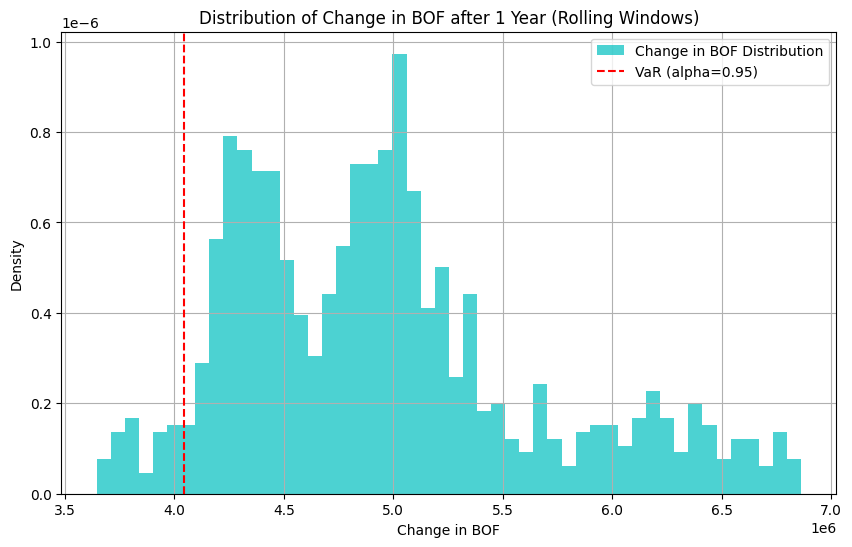

In [194]:
# Step 1: Calculate rolling 1-year (252 trading days) returns
rolling_returns = returns_df.rolling(window=252).apply(lambda x: np.prod(1 + x) - 1, raw=False).dropna()

# Step 2: Calculate assets and liabilities after 1 year for each rolling window
assets_t1 = assets_0 * (1 + rolling_returns)
liabilities_t1 = liabilities_0 * (1 + liability_growth)

# Step 3: Calculate BOF after 1 year for each period
bof_t1 = assets_t1.sum(axis=1) - liabilities_t1  # liabilities_t1 is a scalar, so no axis needed

# Step 4: Calculate the change in BOF from the initial value
bof_change = bof_t1 - (assets_0 - liabilities_0)

# Plot the distribution of BOF changes
plt.figure(figsize=(10, 6))
plt.hist(bof_change, bins=50, alpha=0.7, color='c', label='Change in BOF Distribution', density=True)
plt.axvline(np.percentile(bof_change, 5), color='r', linestyle='--', label='VaR (alpha=0.95)')
plt.title('Distribution of Change in BOF after 1 Year (Rolling Windows)')
plt.xlabel('Change in BOF')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()